In [13]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [14]:
import hopsworks
import pandas as pd

In [15]:
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/187540
Connected. Call `.close()` to terminate connection gracefully.


# Read in Data

In [70]:
wine_df = pd.read_csv("winequality.csv")

In [71]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [72]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Investigate Number of Missing Values per Column

In [73]:
wine_df.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [74]:
# Fill missing data with either random data or a category corresponding to "Unknown"
for column in wine_df.columns:
    if wine_df[column].isna().any() and pd.api.types.is_numeric_dtype(wine_df[column]):
        wine_df.loc[wine_df[column].isna(), column] = [i for i in np.random.choice(range(round(wine_df[column].min()), round(wine_df[column]. max())), wine_df[column].isna().sum())]
    elif wine_df[column].isna().any() and (pd.api.types.is_object_dtype(wine_df[column]) or pd.api.types.is_categorical_dtype(wine_df[column])):
        wine_df[column].fillna("Unknown")


In [75]:
wine_df.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [76]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.218093,0.339581,0.319036,5.451116,0.056024,30.525319,115.744574,0.994697,3.218093,0.530888,10.491801,5.818378
std,1.301752,0.165278,0.145967,4.774916,0.035044,17.749400,56.521855,0.002999,0.160842,0.149351,1.192712,0.873255
min,3.800000,0.000000,0.000000,0.600000,0.000000,1.000000,6.000000,0.987110,2.720000,0.000000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Transform categorical variables into numerical variables

In [77]:
for column in wine_df.columns:
    if pd.api.types.is_categorical_dtype(wine_df[column]) or pd.api.types.is_object_dtype(wine_df[column]):
        one_hot = pd.get_dummies(wine_df[column], prefix=column)
        wine_df = wine_df.drop(column, axis = 1)
        wine_df = wine_df.join(one_hot)

display(wine_df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0,1
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0,1
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0,1
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0,1
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1,0
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.00,11.2,6,1,0
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1,0
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1,0


### Investigate predictive power of columns

In [ ]:
# see https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

<Axes: xlabel='x', ylabel='ppscore'>

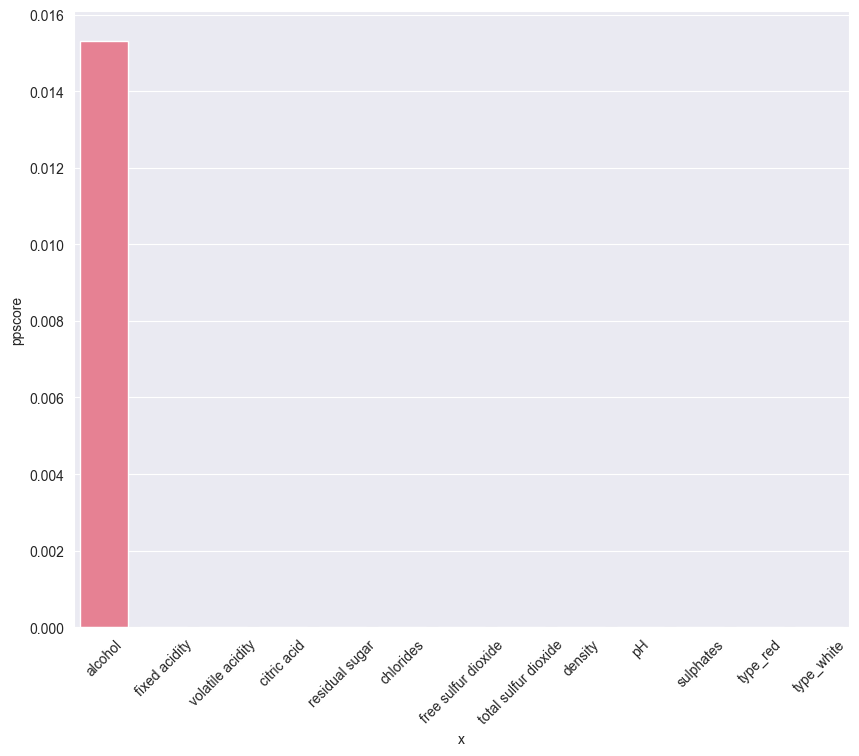

In [95]:
# Method 1: using ppscore
import ppscore as pps


predictors_df = pps.predictors(wine_df, y="quality")
fig, ax = plt.subplots(figsize=(10,8))
ax.tick_params(axis='x', labelrotation=45)
sns.barplot(data=predictors_df, x="x", y="ppscore")

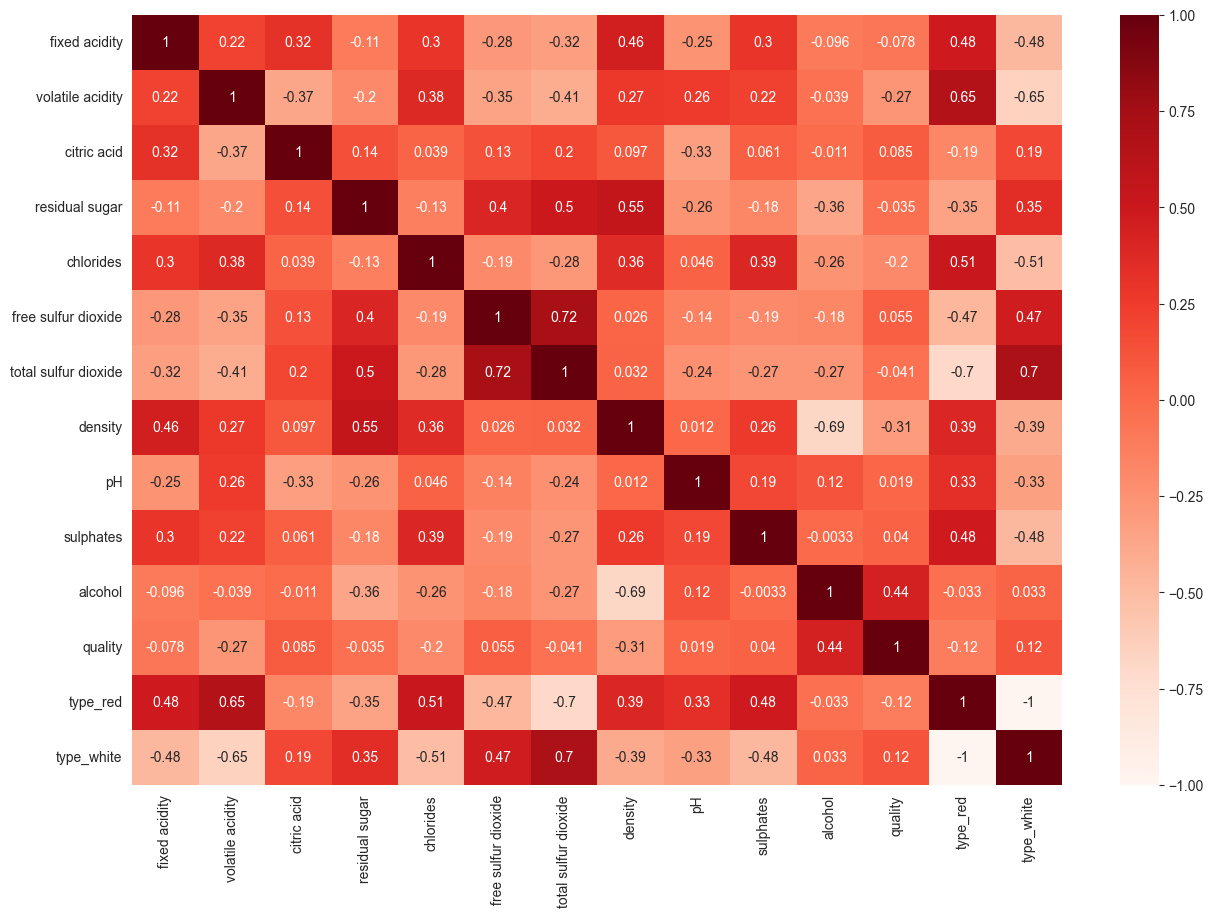

In [98]:
# Method 2: Exploring Correlation
plt.figure(figsize=(15,10))
cor = wine_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [100]:
# Correlation with target variable quality
cor_quality = abs(cor["quality"])

# Selecting only features with correlation coefficient > 0.1
important_features = cor_quality[cor_quality>0.1]
important_features

volatile acidity    0.265869
chlorides           0.200278
density             0.305858
alcohol             0.444319
quality             1.000000
type_red            0.119323
type_white          0.119323
Name: quality, dtype: float64

In [128]:
# Checking for correlation between the important features

wine_df[list(important_features.index)].corr()

# If features are highly intercorrelated, we should only keep one and drop the other
# we should probably drop either red or white and maybe desnisty since it is highly correlated with alcohol

,volatile acidity,chlorides,density,alcohol,quality,type_red,type_white
volatile acidity,1.000000,0.375924,0.270158,-0.039179,-0.265869,0.649370,-0.649370
chlorides,0.375924,1.000000,0.362519,-0.256871,-0.200278,0.512675,-0.512675
density,0.270158,0.362519,1.000000,-0.686745,-0.305858,0.390645,-0.390645
alcohol,-0.039179,-0.256871,-0.686745,1.000000,0.444319,-0.032970,0.032970
quality,-0.265869,-0.200278,-0.305858,0.444319,1.000000,-0.119323,0.119323
type_red,0.649370,0.512675,0.390645,-0.032970,-0.119323,1.000000,-1.000000
type_white,-0.649370,-0.512675,-0.390645,0.032970,0.119323,-1.000000,1.000000


In [149]:
# Embedded Method: Lasso
from sklearn.linear_model import LassoCV
reg = LassoCV()
y = wine_df["quality"]
X = wine_df.loc[:, wine_df.columns != "quality"]
reg.fit(X, y)
coefficients = pd.Series(reg.coef_, index = X.columns)
display(coefficients)

fixed acidity          -0.004112
volatile acidity       -1.359695
citric acid            -0.000000
residual sugar          0.022241
chlorides              -0.000000
free sulfur dioxide     0.005984
total sulfur dioxide   -0.002052
density                -0.000000
pH                      0.044378
sulphates               0.461522
alcohol                 0.338330
type_red                0.053556
type_white             -0.000000
dtype: float64

In [166]:
print("Lasso picked " + str(sum(coefficients != 0)) + " variables and eliminated the other " +  str(sum(coefficients == 0)) + " variables")


Lasso picked 9 variables and eliminated the other 4 variables


Text(0.5, 1.0, 'Feature Importances from Lasso Model')

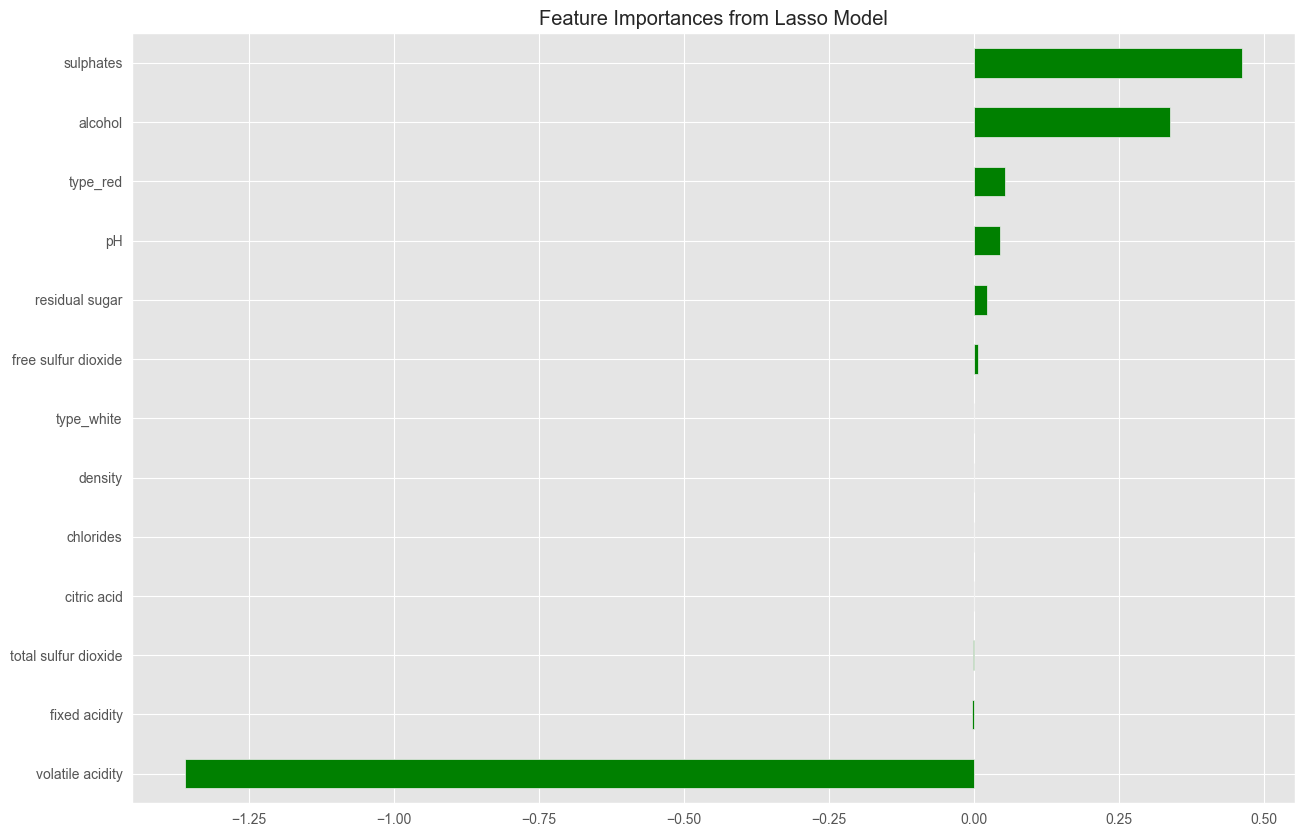

In [148]:
important_coefficients = coefficients.sort_values()
plt.figure(figsize=(15,10))
plt.style.use('ggplot')
important_coefficients.plot(kind = "barh", color="green")
plt.title("Feature Importances from Lasso Model")

## Visualization and Exploration of Final Feature Selection

TODO

### Insert Wine Quality DataFrame into a FeatureGroup

In [ ]:
wine_fg = fs.get_or_create_feature_group(
    name="wine",
    version=1,
    #primary_key=["sepal_length","sepal_width","petal_length","petal_width"],
    description="Wine quality dataset")
wine_fg.insert(wine_df)

### Data Validation

In [ ]:
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

def expect(suite, column, min_val, max_val):
    suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column":column,
            "min_value":min_val,
            "max_value":max_val,
        }
    )
)

In [ ]:
#TODO

"""
suite = ExpectationSuite(expectation_suite_name="iris_dimensions")

expect(suite, "sepal_length", 4.5, 8.0)
expect(suite, "sepal_width", 2.1, 4.5)
expect(suite, "petal_length", 1.2, 7)
expect(suite, "petal_width", 0.2, 2.5)
iris_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")

"""